# Experiment 2: Train CIFAR-10 Text-to-Image Diffusion Model

This notebook trains a text-to-image diffusion model on the CIFAR-10 dataset using classifier-free guidance (CFG).

**Key Differences from Experiment 1 (MNIST):**
- **Image size:** 32×32 (vs 28×28)
- **Channels:** 3 RGB (vs 1 grayscale)
- **Classes:** 10 object categories (airplane, car, bird, etc.)
- **Model capacity:** Larger UNet for more complex images
- **Training:** More epochs needed for convergence

**Model Architecture:**
- Custom UNet2DConditionModel for 32×32 RGB
- CLIP text encoder for text conditioning
- Classifier-free guidance during training

**Training Configuration:**
- 50 epochs
- Batch size: 128
- Learning rate: 1e-4
- Checkpoints every 10 epochs

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Import configuration
from config import (
    EXPERIMENT_2_CONFIG,
    TRAIN_CIFAR10_CONFIG,
    INFERENCE_CONFIG,
    UNET_CIFAR10_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    CIFAR10_CLASSES,
    CHECKPOINTS_DIR,
    DATASET_CACHE_DIR,
    UNET_CIFAR10_CHECKPOINT_PREFIX,
    get_cifar10_unet_checkpoint_path,
    ensure_experiment_2_dirs,
)

# Deep learning frameworks
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random

# Torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

print("Libraries imported successfully")

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# Print configuration
print("CIFAR-10 Training Configuration:")
print(f"  Classes: {CIFAR10_CLASSES}")
print(f"  Epochs: {TRAIN_CIFAR10_CONFIG['num_epochs']}")
print(f"  Batch size: {TRAIN_CIFAR10_CONFIG['batch_size']}")
print(f"  Learning rate: {TRAIN_CIFAR10_CONFIG['learning_rate']}")
print(f"  Checkpoint every: {TRAIN_CIFAR10_CONFIG['checkpoint_every_n_epochs']} epochs")
print()
print("UNet Configuration:")
print(f"  Sample size: {UNET_CIFAR10_CONFIG['sample_size']}")
print(f"  Channels: {UNET_CIFAR10_CONFIG['in_channels']}")
print(f"  Block channels: {UNET_CIFAR10_CONFIG['block_out_channels']}")

CIFAR-10 Training Configuration:
  Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  Epochs: 50
  Batch size: 128
  Learning rate: 0.0001
  Checkpoint every: 10 epochs

UNet Configuration:
  Sample size: 32
  Channels: 3
  Block channels: (64, 128, 256, 256)


In [4]:
# Create directories
ensure_experiment_2_dirs()
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
print("Directory structure created")

Directory structure created


## 2. Load Dataset

In [5]:
# Define transforms - normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # RGB normalization to [-1, 1]
])

# Load CIFAR-10 training dataset
cifar10_train = CIFAR10(
    root=str(DATASET_CACHE_DIR),
    train=True,
    download=True,
    transform=transform
)

print(f"CIFAR-10 training dataset: {len(cifar10_train)} images")
print(f"Image shape: {cifar10_train[0][0].shape}")
print(f"Classes: {CIFAR10_CLASSES}")

100%|██████████| 170M/170M [00:08<00:00, 19.0MB/s] 


CIFAR-10 training dataset: 50000 images
Image shape: torch.Size([3, 32, 32])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


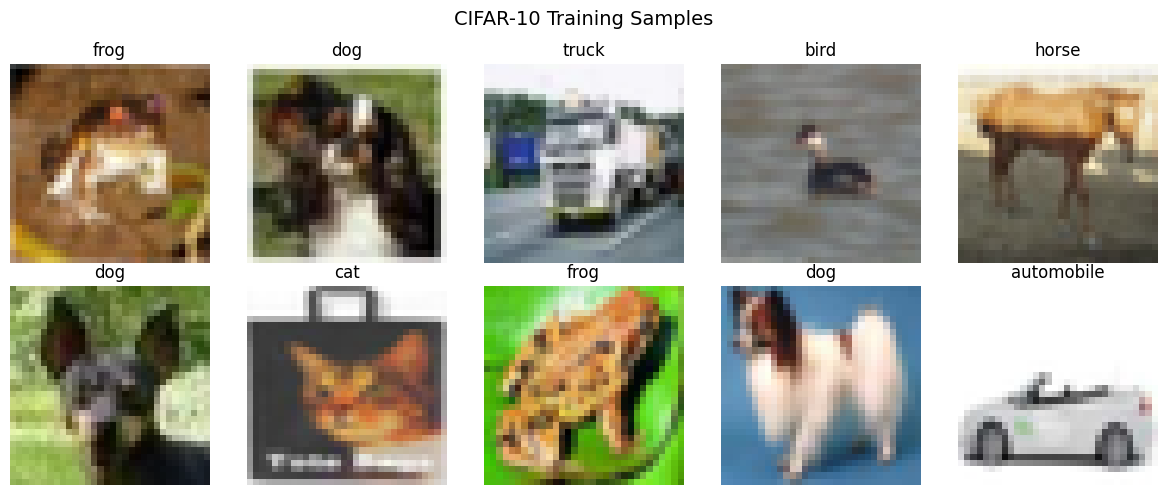

In [6]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    img, label = cifar10_train[i * 500]
    # Denormalize for display
    img_display = (img * 0.5 + 0.5).permute(1, 2, 0).numpy()
    ax.imshow(img_display)
    ax.set_title(CIFAR10_CLASSES[label])
    ax.axis('off')

plt.suptitle('CIFAR-10 Training Samples', fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
# Create custom dataset with text captions
class CIFAR10WithCaptions(Dataset):
    """
    CIFAR-10 dataset with text captions for each image.
    """
    def __init__(self, cifar_dataset, prompt_template="A photo of a {class_name}"):
        self.dataset = cifar_dataset
        self.prompt_template = prompt_template
        self.class_names = CIFAR10_CLASSES
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        class_name = self.class_names[label]
        caption = self.prompt_template.format(class_name=class_name)
        return image, caption, label


# Create dataset with captions
train_dataset = CIFAR10WithCaptions(
    cifar10_train, 
    prompt_template=EXPERIMENT_2_CONFIG["prompt_template"]
)

# Test
img, caption, label = train_dataset[0]
print(f"Sample image shape: {img.shape}")
print(f"Sample caption: '{caption}'")
print(f"Sample label: {label} ({CIFAR10_CLASSES[label]})")

Sample image shape: torch.Size([3, 32, 32])
Sample caption: 'A photo of a frog'
Sample label: 6 (frog)


In [8]:
# Create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_CIFAR10_CONFIG["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

print(f"Dataloader created: {len(train_loader)} batches per epoch")

Dataloader created: 391 batches per epoch


## 3. Load Models

In [9]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100 80GB PCIe
Memory: 85.09 GB


In [10]:
# Import and create custom UNet model
from models.custom_unet_cifar10 import CustomUNet2DConditionModelCIFAR10

unet = CustomUNet2DConditionModelCIFAR10().to(device)

# Print model info
num_params = unet.get_num_parameters()
print(f"✓ Created CIFAR-10 UNet model")
print(f"  Parameters: {num_params:,}")
print(f"  Sample size: {unet.config.sample_size}")
print(f"  In channels: {unet.config.in_channels}")
print(f"  Out channels: {unet.config.out_channels}")

✓ Created CIFAR-10 UNet model
  Parameters: 35,499,523
  Sample size: 32
  In channels: 3
  Out channels: 3


In [11]:
# Load CLIP text encoder and tokenizer
text_encoder = CLIPTextModel.from_pretrained(CLIP_MODEL_NAME).to(device)
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)

# Freeze text encoder
text_encoder.requires_grad_(False)
text_encoder.eval()

print(f"✓ Loaded CLIP text encoder: {CLIP_MODEL_NAME}")
print(f"  Tokenizer max length: {TOKENIZER_MAX_LENGTH}")

✓ Loaded CLIP text encoder: openai/clip-vit-base-patch32
  Tokenizer max length: 8


In [12]:
# Create noise scheduler
noise_scheduler = DDPMScheduler(
    beta_schedule=TRAIN_CIFAR10_CONFIG["beta_schedule"],
    num_train_timesteps=TRAIN_CIFAR10_CONFIG["num_train_timesteps"],
)

print(f"✓ Created DDPM scheduler")
print(f"  Beta schedule: {TRAIN_CIFAR10_CONFIG['beta_schedule']}")
print(f"  Timesteps: {TRAIN_CIFAR10_CONFIG['num_train_timesteps']}")

✓ Created DDPM scheduler
  Beta schedule: squaredcos_cap_v2
  Timesteps: 1000


## 4. Training Setup

In [13]:
# Create optimizer
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=TRAIN_CIFAR10_CONFIG["learning_rate"],
)

print(f"✓ Created AdamW optimizer")
print(f"  Learning rate: {TRAIN_CIFAR10_CONFIG['learning_rate']}")

✓ Created AdamW optimizer
  Learning rate: 0.0001


In [14]:
# Training configuration
CFG_DROPOUT_PROB = 0.1  # Probability of dropping text conditioning (for CFG training)
NUM_EPOCHS = TRAIN_CIFAR10_CONFIG["num_epochs"]
CHECKPOINT_EVERY = TRAIN_CIFAR10_CONFIG["checkpoint_every_n_epochs"]

print(f"Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  CFG dropout probability: {CFG_DROPOUT_PROB}")
print(f"  Checkpoint every: {CHECKPOINT_EVERY} epochs")

Training configuration:
  Epochs: 50
  CFG dropout probability: 0.1
  Checkpoint every: 10 epochs


In [15]:
def save_checkpoint(epoch, unet, optimizer, loss_history):
    """Save training checkpoint."""
    checkpoint_path = get_cifar10_unet_checkpoint_path(epoch)
    
    torch.save({
        "epoch": epoch,
        "unet_state_dict": unet.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss_history": loss_history,
    }, checkpoint_path)
    
    print(f"  ✓ Saved checkpoint: {checkpoint_path}")

print("Checkpoint function defined")

Checkpoint function defined


## 5. Training Loop

In [16]:
def train_one_epoch(epoch, unet, train_loader, optimizer, noise_scheduler, text_encoder, tokenizer, device):
    """
    Train for one epoch with classifier-free guidance.
    """
    unet.train()
    total_loss = 0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for images, captions, labels in progress_bar:
        images = images.to(device)  # (B, 3, 32, 32)
        batch_size = images.shape[0]
        
        # Randomly drop captions for CFG training
        drop_mask = torch.rand(batch_size) < CFG_DROPOUT_PROB
        captions_with_dropout = [
            "" if drop_mask[i] else captions[i] 
            for i in range(batch_size)
        ]
        
        # Encode text
        text_input = tokenizer(
            captions_with_dropout,
            padding="max_length",
            max_length=TOKENIZER_MAX_LENGTH,
            truncation=True,
            return_tensors="pt"
        )
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
        
        # Sample noise
        noise = torch.randn_like(images)
        
        # Sample random timesteps
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=device
        ).long()
        
        # Add noise to images
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        
        # Predict noise
        noise_pred = unet(noisy_images, timesteps, encoder_hidden_states=text_embeddings).sample
        
        # Compute loss
        loss = F.mse_loss(noise_pred, noise)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_loss = total_loss / num_batches
    return avg_loss

print("Training function defined")

Training function defined


In [ ]:
# Main training loop
print(f"\n{'='*70}")
print(f"Starting CIFAR-10 Text-to-Image Training")
print(f"{'='*70}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Total training images: {len(train_dataset)}")
print(f"{'='*70}\n")

loss_history = []
start_time = datetime.now()

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = datetime.now()
    
    # Train one epoch
    avg_loss = train_one_epoch(
        epoch, unet, train_loader, optimizer, 
        noise_scheduler, text_encoder, tokenizer, device
    )
    
    loss_history.append(avg_loss)
    epoch_time = (datetime.now() - epoch_start).total_seconds()
    
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Loss: {avg_loss:.4f} - Time: {epoch_time:.1f}s")
    
    # Save checkpoint
    if epoch % CHECKPOINT_EVERY == 0 or epoch == NUM_EPOCHS:
        save_checkpoint(epoch, unet, optimizer, loss_history)

total_time = (datetime.now() - start_time).total_seconds()

print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"{'='*70}")
print(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"Final loss: {loss_history[-1]:.4f}")


Starting CIFAR-10 Text-to-Image Training
Epochs: 50
Batches per epoch: 391
Total training images: 50000



Epoch 1: 100%|██████████| 391/391 [01:10<00:00,  5.58it/s, loss=0.1042]


Epoch 1/50 - Loss: 0.1423 - Time: 70.0s


Epoch 2: 100%|██████████| 391/391 [01:09<00:00,  5.66it/s, loss=0.0752]


Epoch 2/50 - Loss: 0.0774 - Time: 69.1s


Epoch 3: 100%|██████████| 391/391 [01:09<00:00,  5.65it/s, loss=0.0644]


Epoch 3/50 - Loss: 0.0698 - Time: 69.3s


Epoch 4: 100%|██████████| 391/391 [01:09<00:00,  5.63it/s, loss=0.0790]


Epoch 4/50 - Loss: 0.0674 - Time: 69.4s


Epoch 5: 100%|██████████| 391/391 [01:09<00:00,  5.65it/s, loss=0.0781]


Epoch 5/50 - Loss: 0.0656 - Time: 69.2s


Epoch 6:  27%|██▋       | 105/391 [00:18<00:50,  5.67it/s, loss=0.0566]

## 6. Visualize Training Progress

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('CIFAR-10 Training Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Minimum loss: {min(loss_history):.4f} at epoch {loss_history.index(min(loss_history)) + 1}")

## 7. Test Generation

In [ ]:
@torch.no_grad()
def generate_image(prompt: str, guidance_scale: float, num_images: int = 1) -> torch.Tensor:
    """
    Generate CIFAR-10 images using classifier-free guidance.
    """
    unet.eval()
    
    # Encode text prompt
    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
        return_tensors="pt"
    )
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    
    # Unconditional embeddings
    uncond_input = tokenizer(
        [""] * num_images,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    
    # Concatenate for CFG
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize noise
    latents = torch.randn((num_images, 3, 32, 32), device=device)
    
    # Setup scheduler
    scheduler = DDPMScheduler(
        beta_schedule=INFERENCE_CONFIG["beta_schedule"],
        num_train_timesteps=INFERENCE_CONFIG["num_train_timesteps"]
    )
    scheduler.set_timesteps(INFERENCE_CONFIG["num_inference_steps"])
    
    # Denoising loop
    for t in tqdm(scheduler.timesteps, desc="Generating", leave=False):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Denormalize from [-1, 1] to [0, 1]
    image = (latents / 2 + 0.5).clamp(0, 1)
    
    return image

print("Generation function defined")

In [ ]:
# Test generation for each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, class_name in enumerate(CIFAR10_CLASSES):
    prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=class_name)
    image = generate_image(prompt, guidance_scale=5, num_images=1)
    
    img = image[0].permute(1, 2, 0).cpu().numpy()
    
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.suptitle('Generated CIFAR-10 Samples (guidance scale = 5)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Test different guidance scales
test_class = "cat"
guidance_scales = [0, 2, 5, 10, 20]

fig, axes = plt.subplots(1, len(guidance_scales), figsize=(15, 3))

prompt = f"A photo of a {test_class}"

for i, guidance_scale in enumerate(guidance_scales):
    image = generate_image(prompt, guidance_scale=guidance_scale, num_images=1)
    img = image[0].permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img)
    axes[i].set_title(f'w={guidance_scale}')
    axes[i].axis('off')

plt.suptitle(f'Generated "{test_class}" at different guidance scales', fontsize=14)
plt.tight_layout()
plt.show()

## Summary

This notebook trained a CIFAR-10 text-to-image diffusion model with classifier-free guidance.

**What was accomplished:**
- Loaded CIFAR-10 dataset with text captions ("A photo of a {class}")
- Created custom UNet model for 32×32 RGB images
- Trained with classifier-free guidance (10% caption dropout)
- Saved checkpoints for inference and evaluation

**Next steps:**
1. Run `inference1_t2i_cifar10_cfg.ipynb` to explore the trained model
2. Run `generate_images.ipynb` to generate images for evaluation
3. Run `metrics1_evaluate_cifar10.ipynb` to compute FID and accuracy metrics